input data

In [30]:
import numpy as np
import pandas as pd

In [31]:
#memasukan data
df = pd.read_csv('/content/Weather.csv')
df.head()

,pickup_datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,...,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
0,2015-12-31 00:15:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.5,0.02,Light Rain,rain,0,1,0,0,0,0
1,2015-12-31 00:42:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
2,2015-12-31 00:51:00,7.8,46.0,6.1,43.0,89.0,5.6,3.5,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
3,2015-12-31 01:51:00,7.2,45.0,5.6,42.1,90.0,7.4,4.6,NaN,NaN,...,0.3,0.01,Overcast,cloudy,0,0,0,0,0,0
4,2015-12-31 02:51:00,7.2,45.0,5.6,42.1,90.0,0.0,0.0,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0


In [32]:
#melihat jumlah data
df.shape

(10481, 30)

preprocesing data

In [33]:
#mengambil colom yang ingin diproses
df = df[['pickup_datetime','tempm' ]]
df.head()

,pickup_datetime,tempm
0,2015-12-31 00:15:00,7.8
1,2015-12-31 00:42:00,7.8
2,2015-12-31 00:51:00,7.8
3,2015-12-31 01:51:00,7.2
4,2015-12-31 02:51:00,7.2


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10481 entries, 0 to 10480
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pickup_datetime  10481 non-null  object 
 1   tempm            10476 non-null  float64
dtypes: float64(1), object(1)
memory usage: 163.9+ KB


In [35]:
# mengecek data kosong
df.isnull().sum()

pickup_datetime    0
tempm              5
dtype: int64

In [36]:
#mengisi data yang kosong dengan mean
df['tempm'].fillna(df['tempm'].mean(), inplace=True)

In [37]:
df['date']=pd.to_datetime(df['pickup_datetime'])
df['date'].head()

0   2015-12-31 00:15:00
1   2015-12-31 00:42:00
2   2015-12-31 00:51:00
3   2015-12-31 01:51:00
4   2015-12-31 02:51:00
Name: date, dtype: datetime64[ns]

In [38]:
#menghilangkan waktu pada tanggal
data=df[['date','tempm' ]].copy()
data['date_only'] = data['date'].dt.date

datafinal=data.drop('date',axis=1)
datafinal.set_index('date_only', inplace= True)
datafinal.head()

,tempm
date_only,
2015-12-31,7.8
2015-12-31,7.8
2015-12-31,7.8
2015-12-31,7.2
2015-12-31,7.2


In [39]:
datafinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10481 entries, 2015-12-31 to 2016-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tempm   10481 non-null  float64
dtypes: float64(1)
memory usage: 163.8+ KB


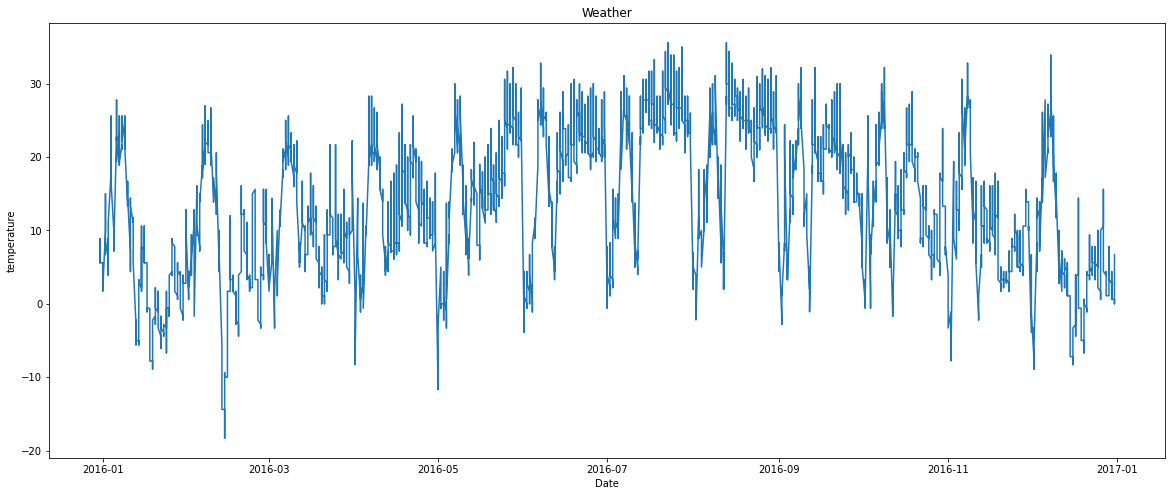

In [40]:
#ploting data
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(datafinal)
plt.title('Weather')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

In [41]:
tanggal = df['date'].values
temperatur = df['tempm'].values

In [42]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [43]:
#membagi data menjadi data train dan test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(temperatur, tanggal, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

8384 2097


membuat model

In [44]:
#membuat model
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

mendapatkan 10% dari skala data

In [45]:
max = df['tempm'].max()
print('Max value : ' )
print(max)

Max value : 
35.6


In [46]:
min = df['tempm'].min()
print('Min Value : ')
print(min)

Min Value : 
-18.3


In [47]:
x = (35.6 - (-18.3)) * (10 / 100)
print(x)

5.390000000000001


membuat fungsi callback

In [48]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

melakukan pelatihan model

In [49]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=500, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/500
84/84 [==============================] - 12s 96ms/step - loss: 61.8607 - mae: 62.3605 - val_loss: 43.6167 - val_mae: 44.1164
Epoch 2/500
84/84 [==============================] - 8s 85ms/step - loss: 30.2881 - mae: 30.7874 - val_loss: 21.1422 - val_mae: 21.6399
Epoch 3/500
84/84 [==============================] - 8s 87ms/step - loss: 14.6035 - mae: 15.0970 - val_loss: 13.3099 - val_mae: 13.8018
Epoch 4/500
84/84 [==============================] - 8s 85ms/step - loss: 10.5814 - mae: 11.0691 - val_loss: 11.9255 - val_mae: 12.4140
Epoch 5/500
84/84 [==============================] - 8s 86ms/step - loss: 9.8521 - mae: 10.3387 - val_loss: 11.3481 - val_mae: 11.8355
Epoch 6/500
84/84 [==============================] - 8s 85ms/step - loss: 9.4220 - mae: 9.9076 - val_loss: 10.9950 - val_mae: 11.4822
Epoch 7/500
84/84 [==============================] - 8s 86ms/step - loss: 9.0928 - mae: 9.5779 - val_loss: 10.7143 - val_mae: 11.2007
Epoch 8/500
84/84 [==============================] -

grafik hasil pembelajaran

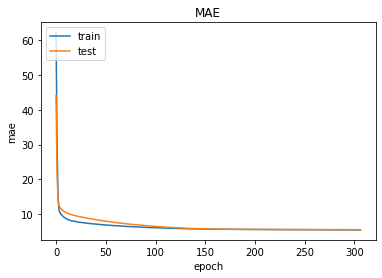

In [50]:
# plot of mae
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

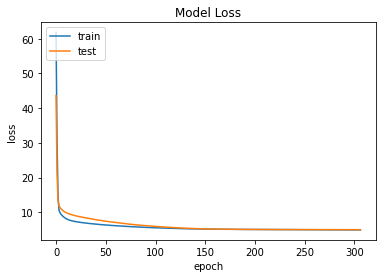

In [51]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()